# Applying MYCN Signature Learned in TARGET data to Cell Lines

**Gregory Way, 2019**

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sys.path.append("../8.gtex-interpret")
from scripts.utils import load_weight_matrix, apply_signature

In [2]:
np.random.seed(123)

In [3]:
%matplotlib inline

## 1. Load NBL Processed Dataset

In [4]:
file = os.path.join('data', 'nbl_celllines_processed_matrix.tsv.gz')
nbl_df = pd.read_table(file, index_col=0)

print(nbl_df.shape)
nbl_df.head(2)

(40, 18628)


,1,2,9,12,13,14,15,16,18,19,...,105375787,106707243,106821730,106865373,107080638,107080644,107181291,107984155,107984923,107987479
CHP134,0.496142,0.000000,0.031914,0.0,0.000000,0.335754,1.000000,0.527104,0.123020,0.101682,...,0.0,0.202001,0.350250,0.0,0.359538,0.0,0.0,0.0,0.398515,0.0
CHP212,0.130269,0.077607,0.384543,0.0,0.047631,0.483361,0.011138,0.680574,0.002162,0.136316,...,0.0,0.030310,0.673424,0.0,0.086474,0.0,0.0,0.0,0.556493,0.0


## 2. Apply Signature Learned by TARGET data

In [5]:
vae_seed = '451283'
vae_k = 200
vae_feature = "vae_111"

In [6]:
weight_df = load_weight_matrix(dataset='TARGET',
                               z_dim=vae_k,
                               seed=vae_seed)
weight_df.head()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,dae_190,dae_191,dae_192,dae_193,dae_194,dae_195,dae_196,dae_197,dae_198,dae_199
gene_id,,,,,,,,,,,,,,,,,,,,,
8337,-0.004849,-0.023897,-0.016095,-0.018362,0.034889,0.008711,0.005634,-0.008216,-0.025272,0.026315,...,0.004625,0.018829,0.066910,0.029290,0.028087,0.053912,0.009322,0.005836,0.023151,0.019846
56849,-0.026866,0.001740,-0.009147,-0.009055,-0.008393,-0.010301,0.009526,-0.006650,0.000642,0.013793,...,-0.047289,-0.116203,0.027144,-0.075229,0.017779,-0.030518,-0.026581,0.030279,-0.151342,-0.064287
5999,-0.025851,-0.000609,-0.004601,-0.013925,-0.003599,-0.007169,0.008380,-0.000327,-0.000511,0.008287,...,-0.061015,-0.102896,-0.013595,-0.062758,0.000425,0.021053,-0.039788,-0.048756,-0.113120,-0.041565
6192,0.000613,0.000113,-0.002125,-0.006721,0.024305,-0.000472,-0.010771,-0.000680,-0.005298,-0.017055,...,-0.014806,0.000281,0.045120,0.028855,0.022516,0.066225,-0.000818,0.016256,0.001300,0.029615
3880,-0.021859,0.000071,-0.008843,-0.001078,-0.020019,-0.002469,0.016229,-0.005949,0.009196,0.020103,...,-0.053898,-0.056254,0.006251,-0.013616,-0.009668,-0.016280,-0.054792,0.022935,-0.110216,-0.029674


In [7]:
result_mycn_df, nbl_missing_genes = (
    apply_signature(weight_df=weight_df,
                    other_df=nbl_df,
                    feature=vae_feature,
                    align=True)
)

use_genes = weight_df.shape[0] - len(nbl_missing_genes)
print('{} ({}%) of genes are used'.format(use_genes, use_genes / weight_df.shape[0] * 100 ))

7653 (95.6625%) of genes are used


In [8]:
result_mycn_df.head()

,vae_111
CHP134,6.253521
CHP212,3.720755
COGN415,4.658529
COGN440,5.322958
COGN453,5.996785


## 3. Align with Phenotype Data

In [9]:
file = os.path.join("download", "nbl_cellline_phenotype.txt")
pheno_df = pd.read_table(file)

pheno_df.head()

,Cell Line,MYCN status,1p36 del,3p26 del,11q23 del,17q21-qter unbal gain,ALK mutation,p53 mutation
0,CHP134,Amplified,LOH p32.3-pter; Gain p34.3-p36.22; Loss p36.22...,Gain/AI p26.3,None,Gain q12-qter,WT,WT
1,CHP212,Amplified,Loss p13.2-pter,Gain/AI p26.3,cnLOH 23.3,Gain q12-qter,WT,WT
2,COGN415,Amplified,Unknown,Unknown,Unknown,Unknown,F1174L,WT
3,COGN440,Amplified,Unknown,Unknown,Unknown,Unknown,WT,WT
4,COGN453,Amplified,Unknown,Unknown,Unknown,Unknown,F1174L,WT


In [10]:
merged_df = (
    result_mycn_df
    .merge(pheno_df,
           left_index=True,
           right_on="Cell Line")
    .reset_index(drop=True)
)

file = os.path.join("results", "mycn_nbl_scores.tsv")
merged_df.to_csv(file, sep='\t')

merged_df.head()

,vae_111,Cell Line,MYCN status,1p36 del,3p26 del,11q23 del,17q21-qter unbal gain,ALK mutation,p53 mutation
0,6.253521,CHP134,Amplified,LOH p32.3-pter; Gain p34.3-p36.22; Loss p36.22...,Gain/AI p26.3,None,Gain q12-qter,WT,WT
1,3.720755,CHP212,Amplified,Loss p13.2-pter,Gain/AI p26.3,cnLOH 23.3,Gain q12-qter,WT,WT
2,4.658529,COGN415,Amplified,Unknown,Unknown,Unknown,Unknown,F1174L,WT
3,5.322958,COGN440,Amplified,Unknown,Unknown,Unknown,Unknown,WT,WT
4,5.996785,COGN453,Amplified,Unknown,Unknown,Unknown,Unknown,F1174L,WT


In [11]:
merged_df['MYCN status'].value_counts()

Amplified        20
Non-amplified    10
Name: MYCN status, dtype: int64

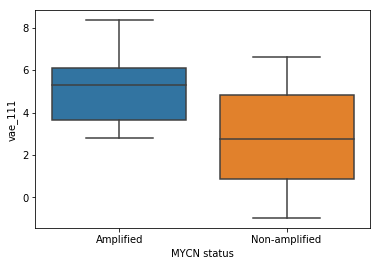

In [12]:
sns.boxplot(x="MYCN status", y='vae_111', data=merged_df);